# Exploring the Fraud Detection Feature Set 
In the [previous notebook](./Data_Acquire_Clean.ipynb), we put together a dataframe of available merchant account information, with approximately **2.9%** of the observations identified as fraudulent cases, over roughly a 1.5 year period. Let's load this dataset and try to shed some additional light on the features to try to get healthy predictors of fraudulent merchants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [9]:
dat = pd.read_csv('./../data/train.csv')

In [15]:
dat.sample(5)

,merchantidentifier,IP_Address_organization,IP_Address_Location,Pierced_IP_address_organization,Pierced_IP_address_location,timezone_differencefromGMT_using_application_device,date_account_opened,state_from_application_address,AreaCodeState,first_transaction_time,first_transaction_amount,dateclosedforfraud,Flag_for_data_with_fraud_outcomes,is_fraud
107554,46746851,AT&T U-VERSE,TEXAS,AT&T U-VERSE,TEXAS,360.0,2014-05-14,TX,TX,2014-05-18 10:28:50,16.12,NaN,1,0
44767,37172957,CLEAR WIRELESS,CALIFORNIA,CLEAR WIRELESS,CALIFORNIA,480.0,2013-05-22,CA,CA,2013-07-05 22:58:13,17.72,NaN,1,0
111632,19887349063,TIME WARNER CABLE,HAWAII,TIME WARNER CABLE,HAWAII,600.0,2015-03-03,HI,HI,2015-03-24 18:23:28,2750.00,NaN,1,0
66549,19969429003,COMCAST CABLE,GEORGIA,COMCAST CABLE,GEORGIA,300.0,2014-06-30,GA,GA,2014-07-10 10:54:25,235.95,NaN,1,0
56008,40649489,COMCAST CABLE,COLORADO,COMCAST CABLE,COLORADO,420.0,2013-07-20,CO,CO,2013-07-26 20:21:46,0.50,NaN,1,0


## Feature Engineering  

Let's ask ourselves the following questions, and build some features if not already available:  
* Is there a correlation between the time taken from account open to first transaction, and fake merchants?  
* Is there anything peculiar about the first transaction amount distribution between normal and fake merchants?  
* How do the location variables interact with each other to identify fake merchants, if at all?  
    * Specifically, interactions between application IP location, pierced IP location, application device timezone, state on the application address, phone number driven location?  
* What can we learn about the merchants themselves? Do merchants with a large presence see more cases of fraud, after normalizing on the dataset? 

--- 

We start by creating a new feature, *time_to_first_txn* which captures the time taken between account open and first transaction.

In [37]:
dat['date_account_opened'] = pd.to_datetime(dat['date_account_opened'])
dat['first_transaction_time'] = pd.to_datetime(dat['first_transaction_time'])

#new feature
dat['time_to_first_txn'] = (dat['first_transaction_time'] - dat['date_account_opened']).apply(lambda date: date.days)

Let's now look at our numericals: time taken to first transaction, and transaction amount, and see how fraudulent cases behave...

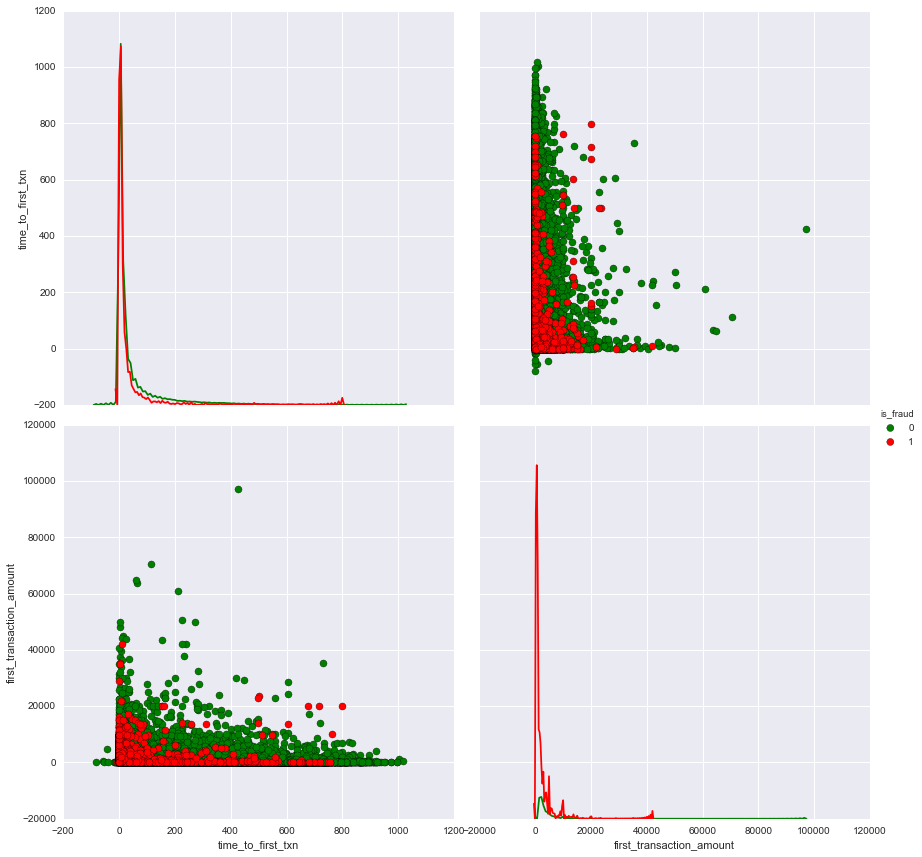

In [63]:
sns.pairplot(dat, vars=['time_to_first_txn','first_transaction_amount'], hue='is_fraud', 
             size=6, aspect=1, diag_kind='kde', plot_kws={'s':50, 'edgecolor':'black'},
            palette={0:'green',1:'red'})

Aha! We observe that while the # of days taken between account open and time to first transaction probably doesn't help discern much between fake and genuine merchants, the *first transaction amount* definitely does! Fraudulent merchants strongly tend to gravitate towards small first transaction amounts.  

> We also note (for later) that there are some seemingly erroneous data points in the dates recorded for account open versus first transaction dates because we see negative days. None of these data points are recorded as fraudulent, so we assume some sort of a data recording error for now. 

Let's take a closer look at the first transaction amount...

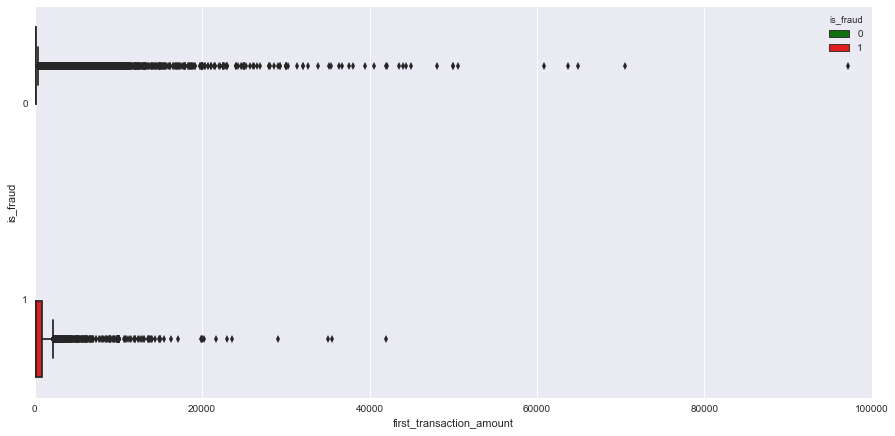

In [108]:
plt.figure(figsize=(15,7))
sns.boxplot(data=dat, y='is_fraud', x='first_transaction_amount',
            hue='is_fraud', palette={0:'green',1:'red'}, orient='h')

We notice that first transaction amounts tend to vary more for fraudulent merchants. Closer look...

[(0, 2500)]

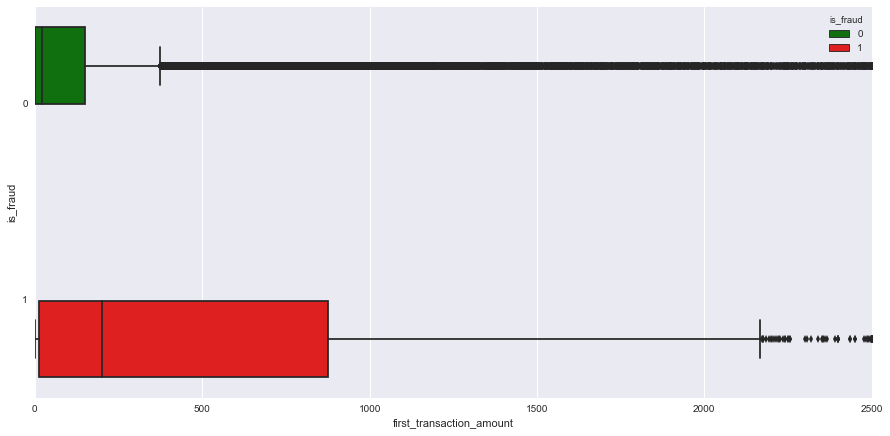

In [142]:
plt.figure(figsize=(15,7))
p=sns.boxplot(data=dat, y='is_fraud', x='first_transaction_amount',
            hue='is_fraud', palette={0:'green',1:'red'}, orient='h')
p.set(xlim=(0,2500))


## IP Time Zone Vs. Application Time Zone

We'd normally expect these two time zones to be the same, although this isn't a rule; but it would be concerning if there were vast differences in the IP time zone and the timezone registered from the registering device. Let's first map the timezones provided. 

In [ ]:
#code to track differnt locations:
#_ _ _ _ _; ip loc, pierced ip loc, app loc, area code loc, pierced ip Vs. device Time Zone; can have 16 different combinations here;
#fraud % by:
# location codes
# organization

#fraud by
# time to first transaction
# first trans amount
